# Generate a Set of Synthetic Data
Generate synthetic data which looks somewhat like a cell from the [CAMP dataset](https://doi.org/10.18126/fdxq-7yul).

In [1]:
%matplotlib inline
from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.models.ecm.components import Resistance, OpenCircuitVoltage, MaxTheoreticalCapacity, ReferenceOCV
from moirae.models.ecm import ECMASOH, ECMTransientVector, ECMInput, ECMMeasurement
from moirae.simulator import Simulator
from moirae.interface import run_online_estimate
from moirae import __version__ as moirae_version
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from batdata.data import BatteryDataset
from batdata.schemas.modeling import ModelMetadata
from shutil import copyfileobj
from hashlib import sha256
from pathlib import Path
from tqdm import tqdm
import numpy as np
import requests

Configuration

In [2]:
data_url = 'https://data.materialsdatafacility.org/mdf_open/camp_2023_v3.5/hdf5/refined/batch_B28A_cell_39.h5'
template_dir = Path('template-data')  # Where to store the tempalte data
num_soc_steps: int = 17  # Number of interpolation steps in the OCV measurement
timestep_duration: float = 5.  # Time between measurements in seconds
output_dir = Path('synth-data')

In [3]:
template_dir.mkdir(exist_ok=True)
output_dir.mkdir(exist_ok=True)

## Download and Parse the Data
Download the data using HTTP and store locally

In [4]:
data_path = template_dir / data_url.split("/")[-1]
print(f'Saving data to {data_path}')

Saving data to template-data\batch_B28A_cell_39.h5


Download if not present

In [5]:
if not data_path.exists():
    with data_path.open('wb') as fp:
        copyfileobj(requests.get(data_url, stream=True).raw, fp)

In [6]:
template_dataset = BatteryDataset.from_batdata_hdf(data_path)

## Get Initial Parameter Estimates for Equivalent Circuit Parameters
Let's start with some educated guesses for the parameters. 

First up, make a model for the open circuit voltage using a regular cycle

In [7]:
initial_cycles = template_dataset.raw_data.query('24 < cycle_number < 40')  # Get cycles after some initial tests

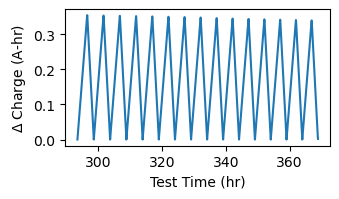

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, -initial_cycles['cycle_capacity'])

ax.set_xlabel('Test Time (hr)')
ax.set_ylabel('$\Delta$ Charge (A-hr)')
fig.tight_layout()

Estimate a capacity by getting the maximum amount of energy added to the battery

In [9]:
cycle_capacities = -initial_cycles.groupby('cycle_number')['cycle_capacity'].min()
cycle_capacities.describe()

count    15.000000
mean      0.346770
std       0.004931
min       0.339110
25%       0.342624
50%       0.347348
75%       0.350804
max       0.353956
Name: cycle_capacity, dtype: float64

In [10]:
initial_capacity = cycle_capacities.median()
print(f'Initial capacity estimate is {initial_capacity:.2f} A-hr')

Initial capacity estimate is 0.35 A-hr


Estimate the Open Circuit Voltage by measuring the voltage at different states of charge during both charge and discharge

In [11]:
discharging = initial_cycles.query('state == "discharging"')
charging = initial_cycles.query('state == "charging"')

In [12]:
def get_voltage_measurments(subset):
    """Determine measurements at different SOCs"""

    voltage_steps = np.zeros((len(set(subset['cycle_number'])), num_soc_steps))
    for i, (_, group) in enumerate(subset.groupby('cycle_number')):
        group = group.sort_values('cycle_capacity')
        f = interp1d(-group['cycle_capacity'], group['voltage'])
        steps = np.linspace(
            -group['cycle_capacity'].max(), 
            -group['cycle_capacity'].min(),
            num_soc_steps
        )
        voltage_steps[i, :] = f(steps)
    return voltage_steps.mean(axis=0)

In [13]:
discharge_volt = get_voltage_measurments(discharging)
charge_volt = get_voltage_measurments(charging)
ocv = 0.5 * (discharge_volt + charge_volt)

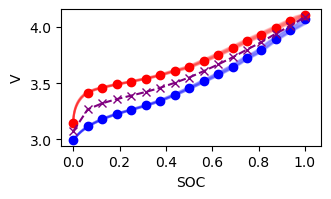

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

soc_values = np.linspace(0, 1, num_soc_steps)
for subset, points, color in [(discharging, discharge_volt, 'blue'), (charging, charge_volt, 'red')]:
    for gid, group in subset.groupby('cycle_number'):
        ax.plot(-group['cycle_capacity'] / initial_capacity, group['voltage'], alpha=0.1, color=color)
    ax.scatter(soc_values, points, marker='o', color=color)
ax.plot(soc_values, ocv, '--x', color='purple')

ax.set_xlabel('SOC')
ax.set_ylabel('V')
fig.tight_layout()

Estimate a SOC-dependent series resistance based on the difference in voltage between charge and discharge and the charge difference

$V_c - V_d = OCV + I_c R - (OCV - I_d R) = (I_c + I_d)R$

In [15]:
charge_current = charging['current'].abs().mean()
discharge_current = discharging['current'].abs().mean()
print(f'Charge current {charge_current:.1f} A. Discharge current {discharge_current:.1f} A')

Charge current 0.1 A. Discharge current 0.2 A


In [16]:
r_serial = (charge_volt - discharge_volt) / (discharge_current + charge_current)
r_serial /= 10  # The r0 estimate is too large because we're not including other sources of resistance

## Build Functions to Generate Data
We'll need a tool to generate an initial set of model parameters and 

In [17]:
def build_initial(
    q_t: float = initial_capacity,
    r0: np.ndarray = r_serial,
    ocv_ref: np.ndarray = ocv,
) -> tuple[ECMASOH, ECMTransientVector]:
    """Build an initial set of parameters 

    Args:
        q_t: Theoretical capacity
        r0: Values for the serial resistance at different SOCs
        ocv_ref: OCV at different SOCs
    Returns
        Tuple of health parameters and initial transient state
    """
    
    asoh = ECMASOH(
        q_t=MaxTheoreticalCapacity(base_values=initial_capacity),
        r0=Resistance(base_values=r0),
        ocv=OpenCircuitVoltage(
            ocv_ref=ReferenceOCV(base_values=ocv_ref, interpolation_style='cubic'),
            ocv_ent={'base_values': 0}
        )
    )
    
    ecm_start = ECMTransientVector(soc=1.)
    return asoh, ecm_start

In [18]:
asoh_start, state_start = build_initial()

Create a tool to generate a random cycle

In [19]:
def cycle_protocol(asoh: ECMASOH, rng: np.random.RandomState, start_time: float = 0.0):
    """
    Function to return list of ECMInputs corresponding to a new cycle

    Args: 
        asoh: A-SOH object to be used
        rng: Random number generator
        start_time: time at which to start this cycle in seconds
    
    Yields:
        A progression of ECMInputs for the cycle
    """

    # Get the Qt and CE, which will help determine the currents
    qt = asoh.q_t.amp_hour
    ce = asoh.ce

    # Now, let's choose rest durations and C-rates
    rest0, rest1, rest2 = rng.integers(low=5, high=10, size=3)
    rest0 *= 60
    rest1 *= 2 * 60
    rest2 *= 60
    dischg_rate, chg_rate = np.array([1.5, 0.5]) + rng.random(size=2)

    # TODO (wardlt): Victor's original implementation had randomly-sized timesteps
    # I've opted to go with fixed size for now
    current_time = start_time
    def update_timestamps_curr(current_time: float, duration: float, curr: float) -> None:
        """
        Helper to populate timestamps and currents.

        Args:
            duration: duration of segment in seconds
            curr: value of current to be used. 
        Yields: 
            A series of ECM inputs at gradually-increaseing times
        """
        steps = int(np.ceil(duration / timestep_duration))
        for time in np.linspace(current_time, current_time + duration, steps + 1)[:-1]:
            yield ECMInput(time=time, current=curr)

    # Rest 0
    yield from update_timestamps_curr(current_time, duration=rest0, curr=0.0)
    current_time += rest0

    # Discharge
    dischg_duration = 3600.0 / dischg_rate
    dischg_curr = -(qt * dischg_rate)
    yield from update_timestamps_curr(current_time, duration=dischg_duration, curr=dischg_curr)
    current_time += dischg_duration

    # Rest 1
    yield from update_timestamps_curr(current_time, duration=rest1, curr=0.0)
    current_time += rest1

    # Charge
    chg_duration = 3600.0 / chg_rate
    chg_curr = (qt * chg_rate) / ce
    yield from update_timestamps_curr(current_time, duration=chg_duration, curr=chg_curr)
    current_time += chg_duration

    # Rest 2
    yield from update_timestamps_curr(current_time, duration=rest2, curr=0.0)
    current_time += rest2

Simulate a few cycles

In [20]:
def run_simulation(num_cycles: int, asoh: ECMASOH, state: ECMTransientVector, seed: int=1) -> Simulator:
    """Run an ECM simulation for a set number of cycles

    Args:
        num_cycles: Number of cycles to run
        asoh: Initial ASOH
        state: Initial transient state
        seed: Random seed for the cycling protocol
    Returns:
        Simulator object ready with history already populated
    """
        
    simulator = Simulator(
        model=ECM(),
        asoh=asoh,
        initial_input=ECMInput(),
        transient_state=state,
        keep_history=True
    )
    
    rng = np.random.default_rng(seed)
    start_time = 0.
    for cycles in tqdm(range(num_cycles)):
        for inputs in cycle_protocol(simulator.asoh, rng, start_time=start_time):
            simulator.step(inputs)
        start_time = simulator.previous_input.time[0, 0] + timestep_duration
    
    return simulator

In [21]:
simulator = run_simulation(16, asoh_start, state_start)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


In [22]:
df = simulator.to_dataframe()

Plot the results

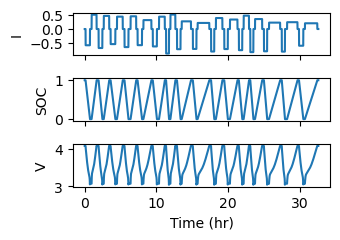

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 2.5), sharex=True)

for ax, c, yl in zip(axs, ['current', 'soc', 'terminal_voltage'], ['I', 'SOC', 'V']):
    ax.plot(df['time'] / 3600, df[c])
    ax.set_ylabel(yl)

axs[-1].set_xlabel('Time (hr)')
fig.tight_layout()

Save to a battery HDF5 file

In [24]:
def to_hdf5(data_dir: Path, simulator: Simulator, asoh: ECMASOH) -> Path:
    """Save the synthetic data to a uniquely-named data file

    Adds the ASOH parameters 
    Generates a hash based on the a

    Args:
        data_dir: Path in which to save HDF5 files
        simulator: Completed cycling experiment
        asoh: Input parameters
    Returns:
        Path to the saved file
    """

    # Convert the simulation data to BatData format then add metadata
    assert asoh.batch_size == 1, 'I have not implemented batch support'
    dataset = simulator.to_batdata(extra_columns=True)[0]
    dataset.metadata.is_measurement = False
    dataset.metadata.modeling = ModelMetadata(
        name='Moirae',
        version=moirae_version,
        type='empirical',
        models=['BatteryEquivalentCircuitModel'],
        parameters={'asoh': asoh_start}
    )

    # Make a hash based on the metadata
    run_hash = sha256(dataset.metadata.model_dump_json(exclude_defaults=True).encode()).hexdigest()[-8:]
    dataset.to_batdata_hdf(
        data_dir / f'ecm-run-{run_hash}.hdf5',
        complevel=9
    )

In [25]:
%%time
to_hdf5(output_dir, simulator, asoh_start)

CPU times: total: 46.9 ms
Wall time: 276 ms
